# ECG Signal Classification with Deep Learning: Leveraging Long Short-Term Memory (LSTM) for Accurate Arrhythmia Detection

### Connecting with the Google driver

DataSet Used: MIT-BIH Arrhythmia Database

https://drive.google.com/file/d/1qyX9jijxe-p9H3_Itjs-DJRzAht2NPvN/view?usp=drive_link

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


kaggle ECG Dataset: https://www.kaggle.com/datasets/sadmansakib7/ecg-arrhythmia-classification-dataset

### Importing the required dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

### Loading and Analysing the ECG Dataset

Loading ECG Dataset

In [ ]:
filepath = '/content/drive/MyDrive/ECG Dataset/MIT-BIH Arrhythmia Database.csv'
data = pd.read_csv(filepath)

Exploratory ECG Dataset Analysis

In [ ]:
data.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


In [ ]:
data.shape

(100689, 34)

### Data Preprocessing

Extracted features and labels from the dataset

In [ ]:
x_data = data.iloc[:, 2:]
y_label = data[['type']]

Handled class imbalance by resampling data

In [ ]:
original_class_distribution = data['type'].value_counts()
print("Original class distribution:")
print(original_class_distribution)

Original class distribution:
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: type, dtype: int64


In [ ]:
majority_class = original_class_distribution.idxmax()
majority_class_count = original_class_distribution.max()

target_samples = majority_class_count

upsampled_data = pd.DataFrame()

for label in original_class_distribution.index:
    class_data = data[data['type'] == label]

    if label == majority_class:
        upsampled_data = pd.concat([upsampled_data, class_data])
    else:
        upsampled_data = pd.concat([upsampled_data, resample(class_data, replace=True, n_samples=target_samples, random_state=42)])

balanced_class_distribution = upsampled_data['type'].value_counts()
print("\nBalanced class distribution:")
print(balanced_class_distribution)


Balanced class distribution:
N       90083
VEB     90083
SVEB    90083
F       90083
Q       90083
Name: type, dtype: int64


Plot pie charts for the original and balanced class distributions

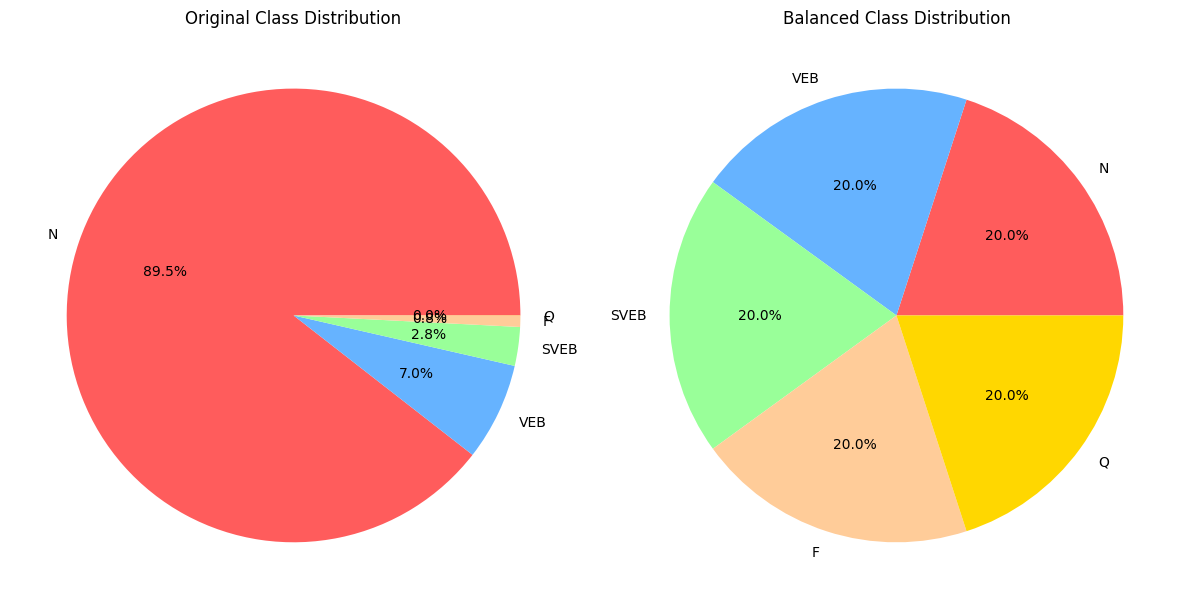

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(original_class_distribution, labels=original_class_distribution.index, autopct='%1.1f%%', colors=['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('Original Class Distribution')

plt.subplot(1, 2, 2)
plt.pie(balanced_class_distribution, labels=balanced_class_distribution.index, autopct='%1.1f%%', colors=['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('Balanced Class Distribution')

plt.tight_layout()
plt.show()

Handle class imbalance by resampling data

In [ ]:
upsampled_data = pd.DataFrame()
target_samples = y_label['type'].value_counts().max()

for label in y_label['type'].unique():
    class_data = data[data['type'] == label]
    if len(class_data) < target_samples:
        upsampled_data = pd.concat([upsampled_data, resample(class_data, replace=True, n_samples=target_samples, random_state=42)])
    else:
        upsampled_data = pd.concat([upsampled_data, class_data])

Resampled data

In [ ]:
x_data = upsampled_data.iloc[:, 2:]
y_label = upsampled_data[['type']]

### Label Encoding

Encoded categorical labels

In [ ]:
label_encoder = LabelEncoder()
y_label_encoded = label_encoder.fit_transform(y_label['type'])
y_label_one_hot = to_categorical(y_label_encoded)

### Data Splitting

Split the data into training and testing sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_label_one_hot, test_size=0.2, random_state=42)

### Scaling and Reshape

Scaled the feature data

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Reshape for LSTM input

In [ ]:
x_train_reshaped = x_train_scaled[..., np.newaxis]
x_test_reshaped = x_test_scaled[..., np.newaxis]

print("x_train_reshaped shape:", x_train_reshaped.shape)
print("y_train shape:", y_train.shape)
print("x_test_reshaped shape:", x_test_reshaped.shape)
print("y_test shape:", y_test.shape)

x_train_reshaped shape: (360332, 32, 1)
y_train shape: (360332, 5)
x_test_reshaped shape: (90083, 32, 1)
y_test shape: (90083, 5)


### Model Architecture

Model Definition

In [ ]:
model = Sequential([
    LSTM(units=50, activation='tanh', input_shape=(x_train_reshaped.shape[1], 1)),
    Dense(units=len(label_encoder.classes_), activation='softmax')
])

Compile the model


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Model Training and Evaluation

Evaluate the model on the test set

In [ ]:
history = model.fit(x_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
9009/9009 [==============================] - 153s 17ms/step - loss: 0.4182 - accuracy: 0.8452 - val_loss: 0.2705 - val_accuracy: 0.9062
Epoch 2/10
9009/9009 [==============================] - 161s 18ms/step - loss: 0.1818 - accuracy: 0.9381 - val_loss: 0.1484 - val_accuracy: 0.9499
Epoch 3/10
9009/9009 [==============================] - 161s 18ms/step - loss: 0.1220 - accuracy: 0.9602 - val_loss: 0.1132 - val_accuracy: 0.9644
Epoch 4/10
9009/9009 [==============================] - 172s 19ms/step - loss: 0.0963 - accuracy: 0.9694 - val_loss: 0.0818 - val_accuracy: 0.9738
Epoch 5/10
9009/9009 [==============================] - 152s 17ms/step - loss: 0.0787 - accuracy: 0.9749 - val_loss: 0.0681 - val_accuracy: 0.9785
Epoch 6/10
9009/9009 [==============================] - 161s 18ms/step - loss: 0.0680 - accuracy: 0.9783 - val_loss: 0.0762 - val_accuracy: 0.9754
Epoch 7/10
9009/9009 [==============================] - 159s 18ms/step - loss: 0.0604 - accuracy: 0.9813 - val_loss: 0

Evaluate the model on the test set

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=0)
print(f'Test set accuracy: {test_accuracy * 100:.2f}%')

Test set accuracy: 98.50%


Making predictions on the test set

In [ ]:
y_test_pred_probs = model.predict(x_test_reshaped)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
print(y_test_pred)

2816/2816 [==============================] - 17s 6ms/step
[4 3 1 ... 0 2 1]


Classification Report

In [ ]:
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18304
           1       0.98      0.96      0.97     18061
           2       1.00      1.00      1.00     17877
           3       0.97      0.99      0.98     17943
           4       0.98      0.98      0.98     17898

    accuracy                           0.98     90083
   macro avg       0.99      0.99      0.98     90083
weighted avg       0.99      0.98      0.98     90083



### Final Result Visualization

Plotting the accuracy

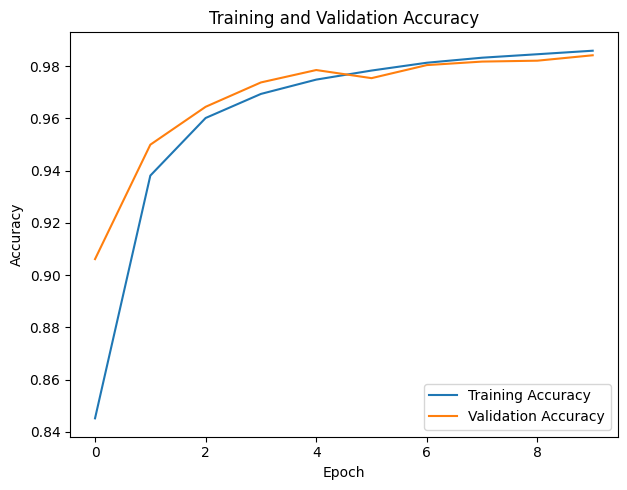

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Plotting the loss

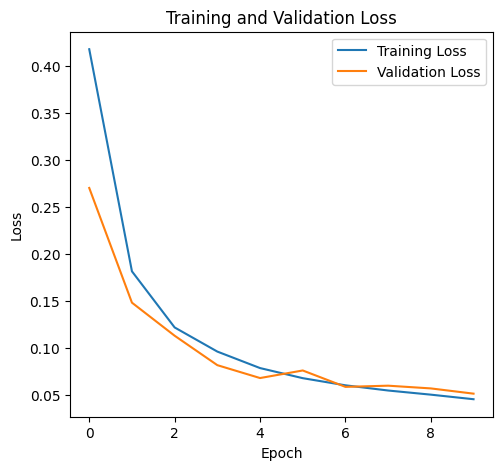

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Plotting the Validation accuracy

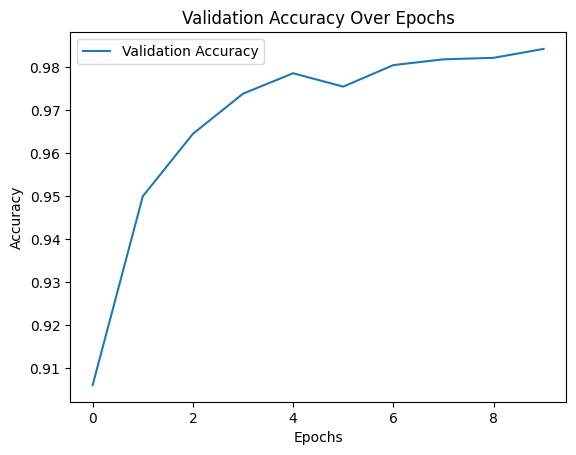

In [ ]:
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Plotting the Validation loss

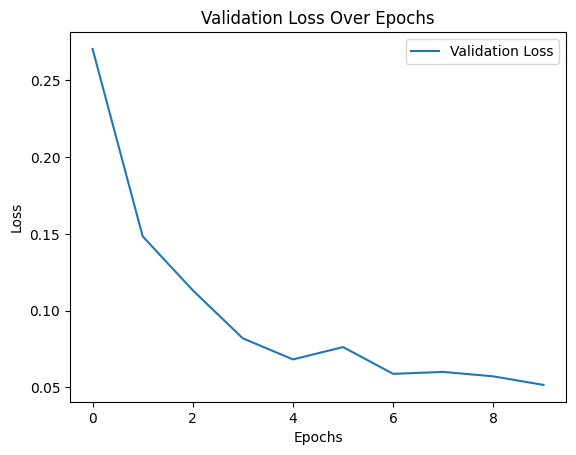

In [ ]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 10655 (41.62 KB)
Trainable params: 10655 (41.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
